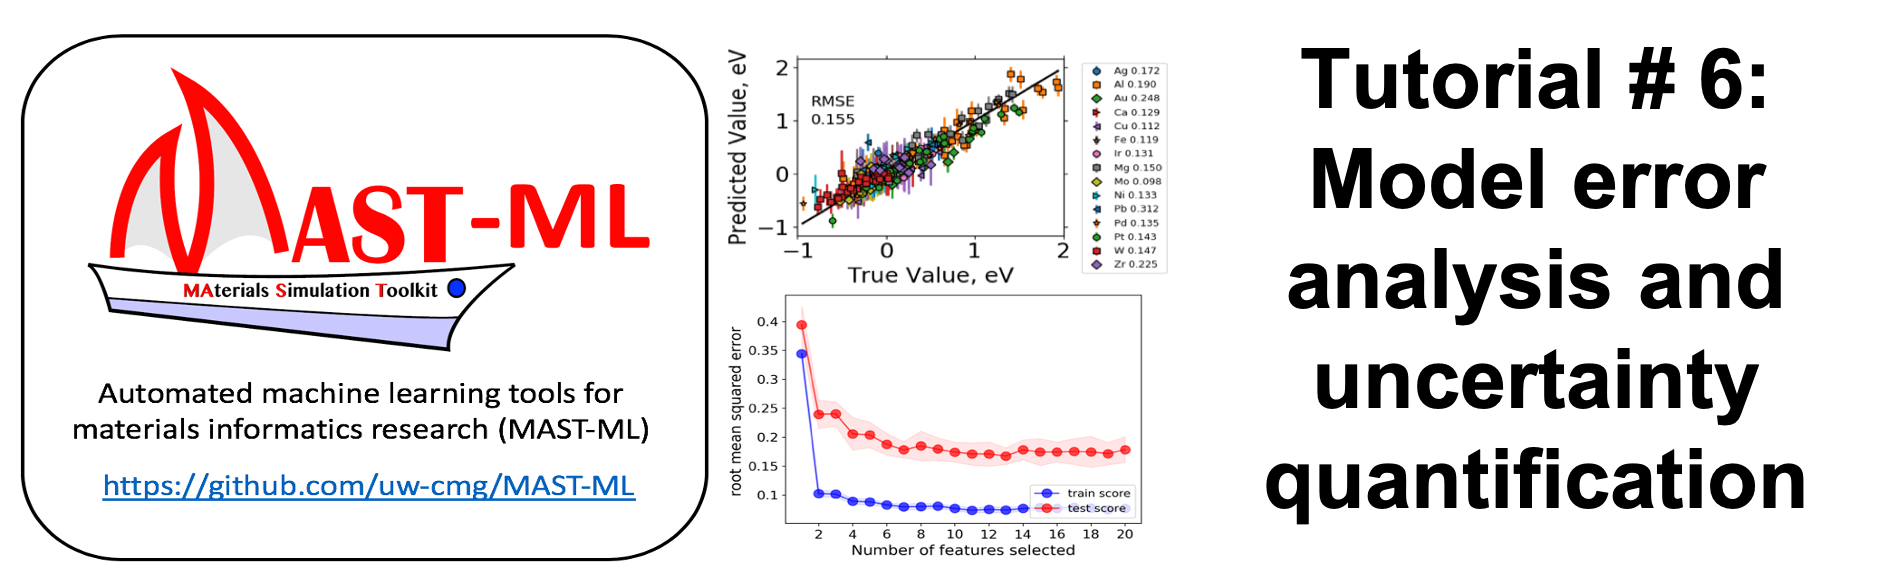

# Welcome to the sixth MAST-ML tutorial notebook, model error analysis and uncertainty quantification with MAST-ML! 

## In this notebook, we will learn about how MAST-ML can be used to:

1. [Set up MAST-ML on Colab and begin session](#task1)
2. [Assess the true and predicted errors of our model, and some useful measures of their statistical distributions](#task2)
3. [Explore different methods of quantifying and calibrating model uncertainties](#task3)
4. [Compare the uncertainty quantification behavior of Bayesian and ensemble-based models](#task4)


## Task 1: Set up MAST-ML on Colab and begin session <a name="task1"></a>

If you are working on Google Colab and need to install MAST-ML, 
begin by pip installing MAST-ML to the Colab session
and install the needed dependencies:

In [ ]:
!pip install mastml
!pip install git+git://github.com/scikit-learn-contrib/forest-confidence-interval.git

Sync your Google drive to Colab so that we can save MAST-ML results to our Google
Drive. If we save to the Colab session, the data will be deleted when the session 
ends.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Here we import the MAST-ML modules used in this tutorial

In [ ]:
from mastml.mastml import Mastml
from mastml.datasets import LocalDatasets
from mastml.preprocessing import SklearnPreprocessor
from mastml.models import SklearnModel
from mastml.data_splitters import SklearnDataSplitter
import mastml
import os
try:
    data_path = os.path.join(mastml.__path__._path[0], 'data')
except:
    data_path = os.path.join(mastml.__path__[0], 'data')

Here, we set the name of the savepath to save MAST-ML results to, and initialize
our MAST-ML run

When the above command is run, a new folder with the name designated SAVEPATH is created.
This is where all of the output for the current MAST-ML run will be saved to.
Note that you can perform multiple runs with the same folder name, and the current datetime
will be appended to the name so that no data is lost or overwritten.

In [ ]:
SAVEPATH = 'drive/MyDrive/MASTML_tutorial_6_ErrorAnalysis_UncertaintyQuantification'

mastml_instance = Mastml(savepath=SAVEPATH)
savepath = mastml_instance.get_savepath

## Task 2: Assess the true and predicted errors of our model, and some useful measures of their statistical distributions <a name="task2"></a>

In this tutorial, we will again use the diffusion dataset that we examined in the 
previous tutorial. Here, we use the LocalDatasets module to load in the diffusion dataset. 

In [ ]:
target = 'E_regression'

extra_columns = ['Material compositions 1', 'Material compositions 2']

d = LocalDatasets(file_path=data_path+'/diffusion_data_selectfeatures.xlsx', 
                  target=target, 
                  extra_columns=extra_columns, 
                  group_column='Material compositions 1',
                  testdata_columns=None,
                  as_frame=True)

# Load the data with the load_data() method
data_dict = d.load_data()

# Let's assign each data object to its respective name
X = data_dict['X']
y = data_dict['y']
X_extra = data_dict['X_extra']
groups = data_dict['groups']
X_testdata = data_dict['X_testdata']

Only certain types of ML models can be used to establish predicted errors: they consist of Bayesian methods,
namely Gaussian Process Regression, and Ensemble methods, such as random forest, gradient boosting regression,
or the general EnsembleModel() object we explored in Tutorial 4.

Here, we are going to begin by using a random forest model. To perform the error analysis, we designate "Error"
in the plots field (you can also add "Scatter" and "Histogram" to make the parity plots and histograms we've been
analyzing in previous tutorials, but they are removed here for simplicity). Secondly, we can specify the error
analysis method (pertains to ensemble methods only). Here, we are using "stdev_weak_learners". What this method
does is calculates the error bar on each data point as the standard deviation of each weak learner prediction. In
the context of random forest, each decision tree predicts the value of a data point: the average is the predicted
value, and the standard deviation on that value is the error bar.

To examine model errors in detail, it is best to perform many instances of nested cross validation. In this tutorial,
we will just do one repeat of 5-fold CV to keep the calculation time short.

In [ ]:
preprocessor = SklearnPreprocessor(preprocessor='StandardScaler', as_frame=True)

model_rf = SklearnModel(model='RandomForestRegressor', n_estimators=150)

metrics = ['r2_score', 'mean_absolute_error', 'root_mean_squared_error', 'rmse_over_stdev']

splitter = SklearnDataSplitter(splitter='RepeatedKFold', n_repeats=1, n_splits=5)

splitter.evaluate(X=X,
                  y=y, 
                  models=[model_rf],
                  mastml=mastml_instance,
                  preprocessor=preprocessor,
                  metrics=metrics,
                  plots=['Error'],
                  savepath=savepath,
                  X_extra=X_extra,
                  nested_CV=True,
                  error_method='stdev_weak_learners', 
                  verbosity=3,
                  parallel_run=True)

There are five main types of error plots that MAST-ML produces that are worth examining in more detail:

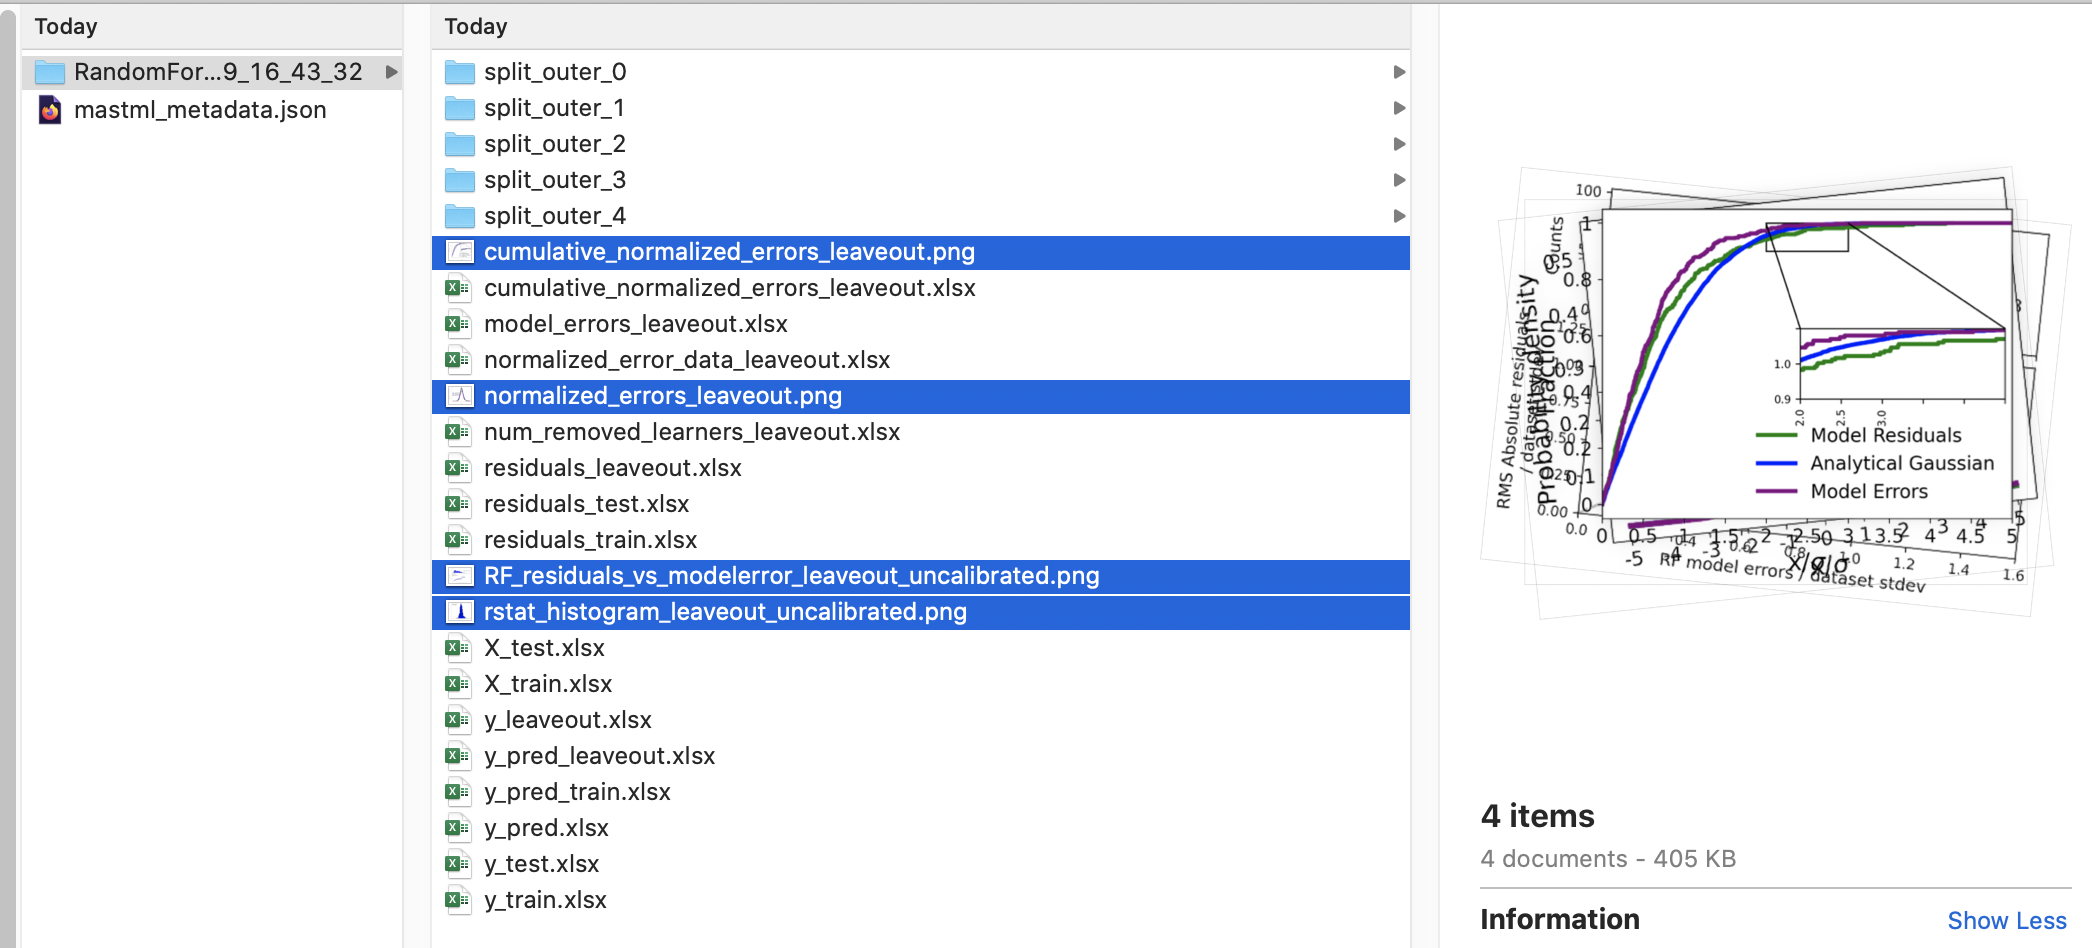

### The "r-statistic" plot:
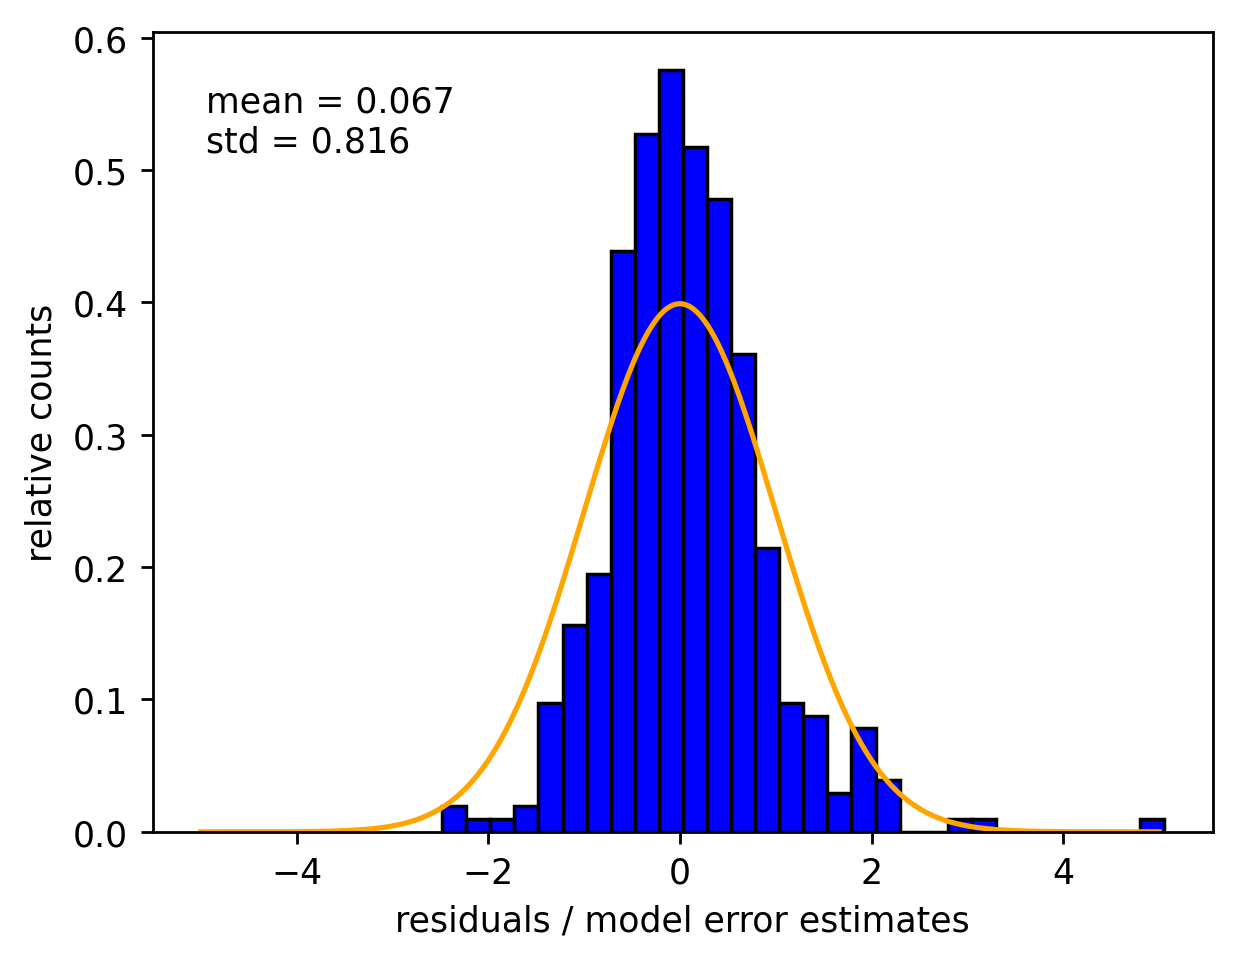

This plot histograms a value we have come to call the "r-statistic", it is a reduced error value which is defined here as the true model error (residuals) divided by the predicted model error (error bars). If the model error estimates are good estimates of the true error, this distribution should be normal with mean zero and standard 
deviation of one. We can see that the standard deviation is less than one here- we will discuss the implications of this more below.

### The normalized error distribution plot:
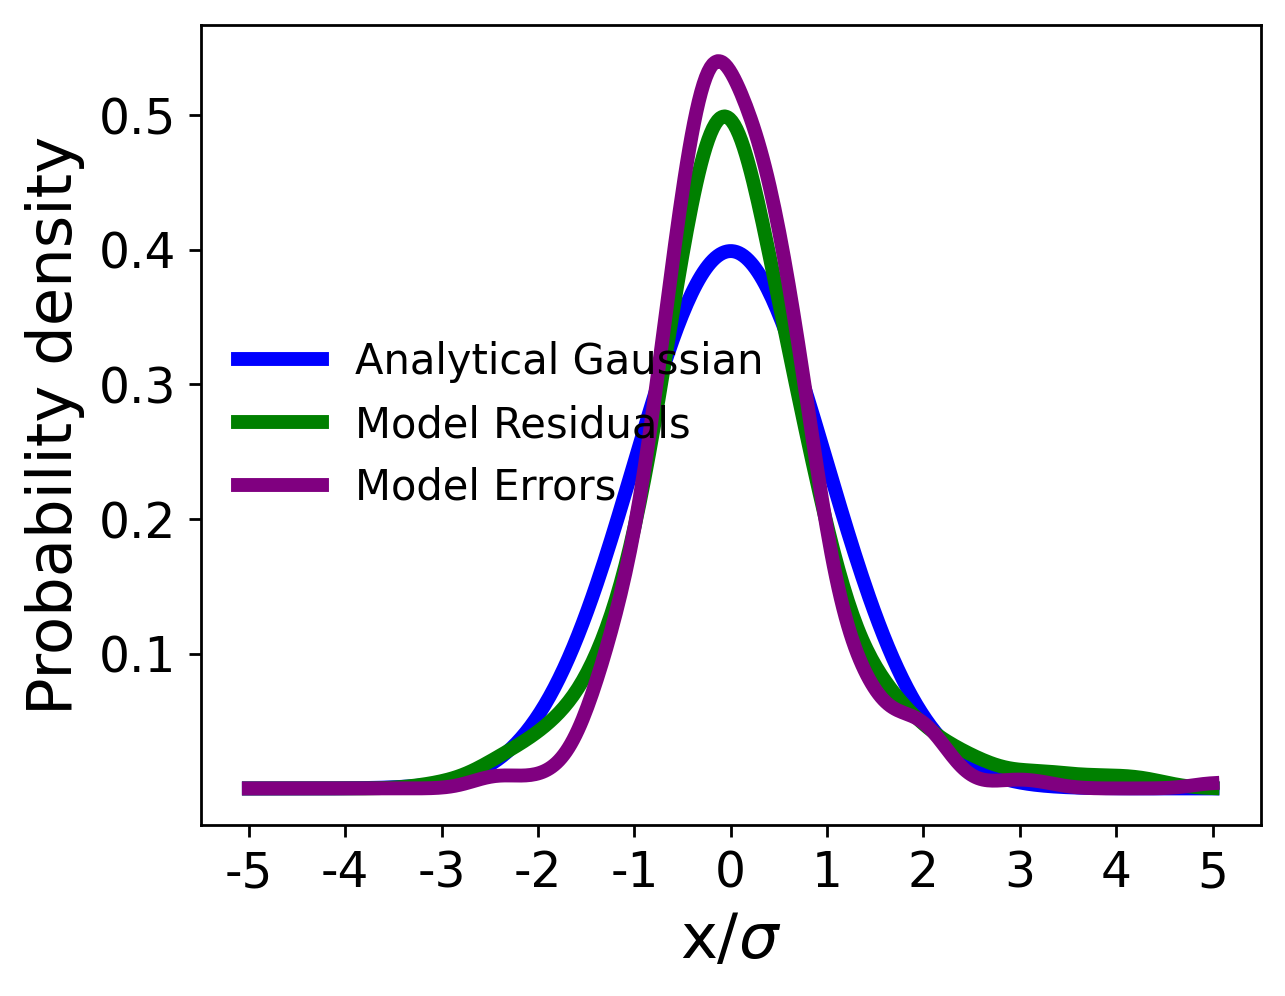

This plot is similar to the r-statistic plot in that it shows the distribution of the r-statistic values (in purple). Instead of a histogram a smooth distribution is made. Also shown are a normal distribution (in blue), and the distribution of normalized residuals (in green). The normalized residuals are calculated as residuals divided by the dataset standard deviation. We can see the purple distribution is skinnier than the normal distribution, consistent with the r-statistic having standard deviation less than one.

### Cumulative normalized error distribution:
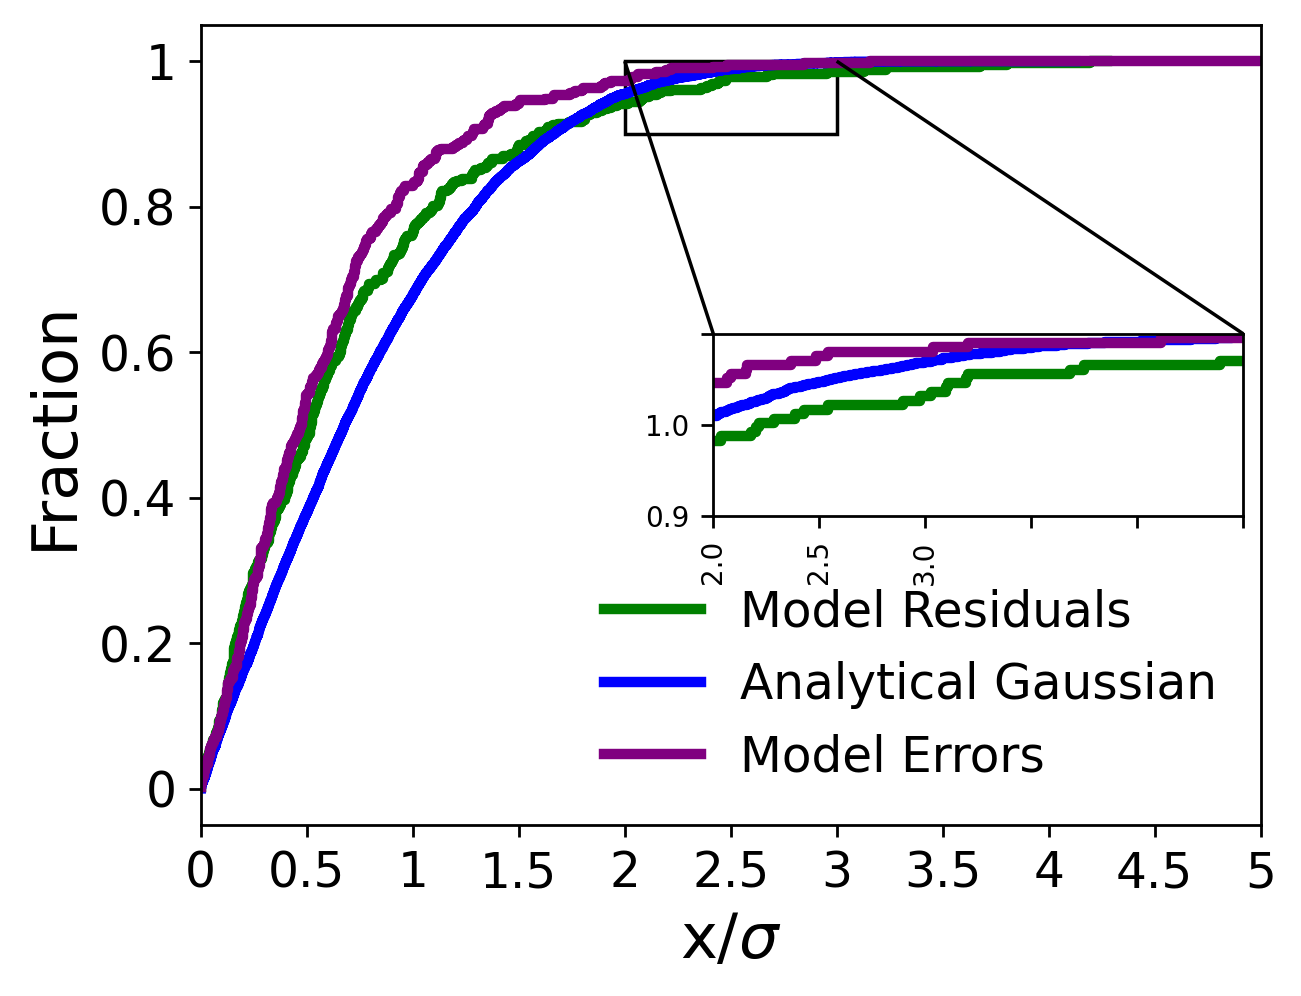

This plot contains the same data as the normalized error distribution, except it is now plotted in as a cumulative distribution (i.e. all curves will converge to 1 as the reduced error x/sigma increases). Once again, the normal distribution is in blue, the normalized residuals distribution is in green, and the r-statistic (normalized model errors) are in purple. Both the green and purple curves lie to the left of the normal distribution, indicating that the denominator of x/sigma (for purple, the model error bars) are too large, i.e. the model is overestimating the true error.


### Quantile-quantile (QQ) plot:
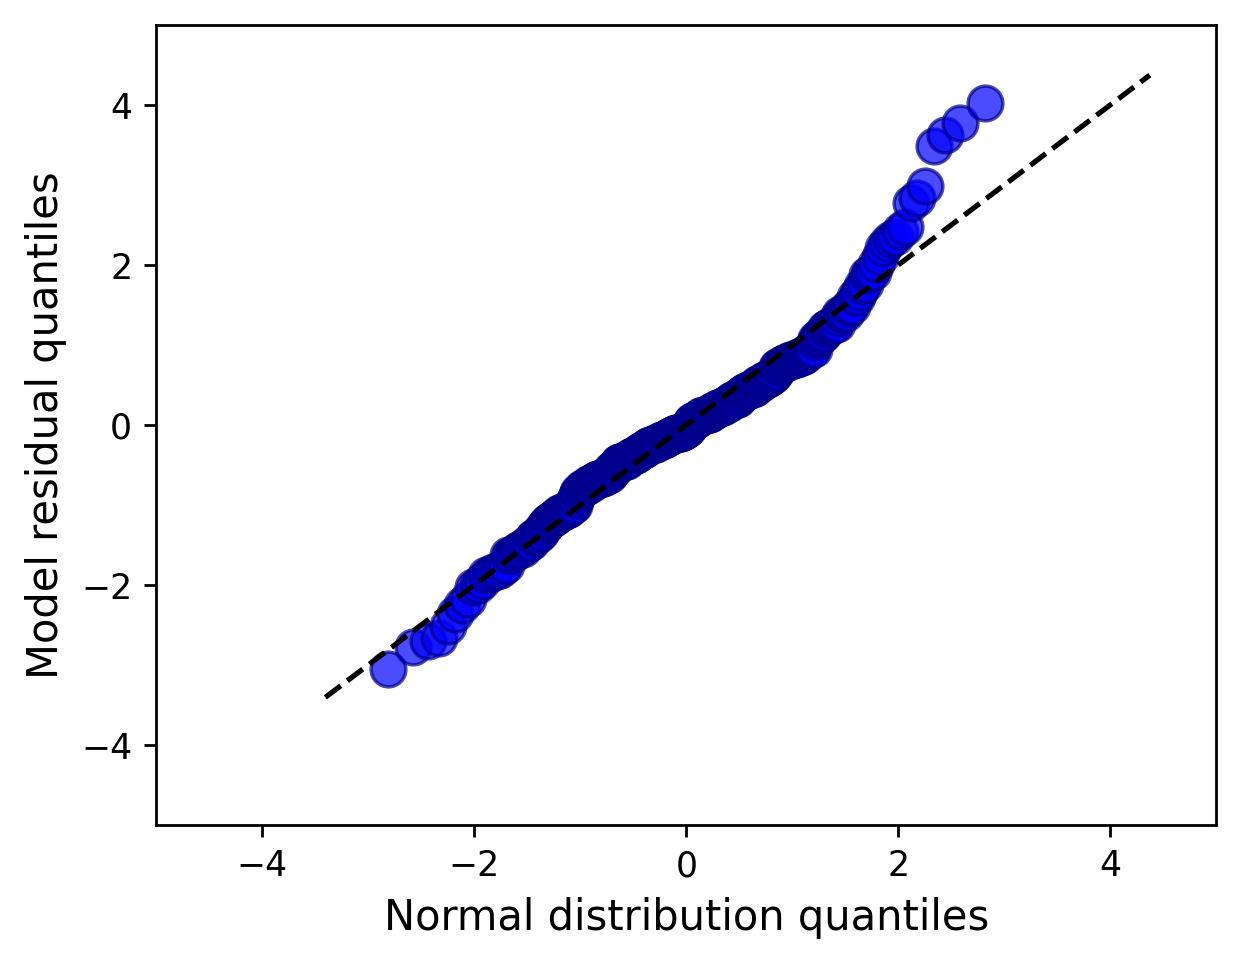

The QQ plot organizes the model residuals into quantiles. Then, these quantiles are plotted against the quantiles one would expect if the residuals were normally distributed. This visualization can be used to detect anomalies in the model residuals which would point to behavior that may deviate signficantly from a normal distribution


### Residuals vs. Error (RvE) plot:
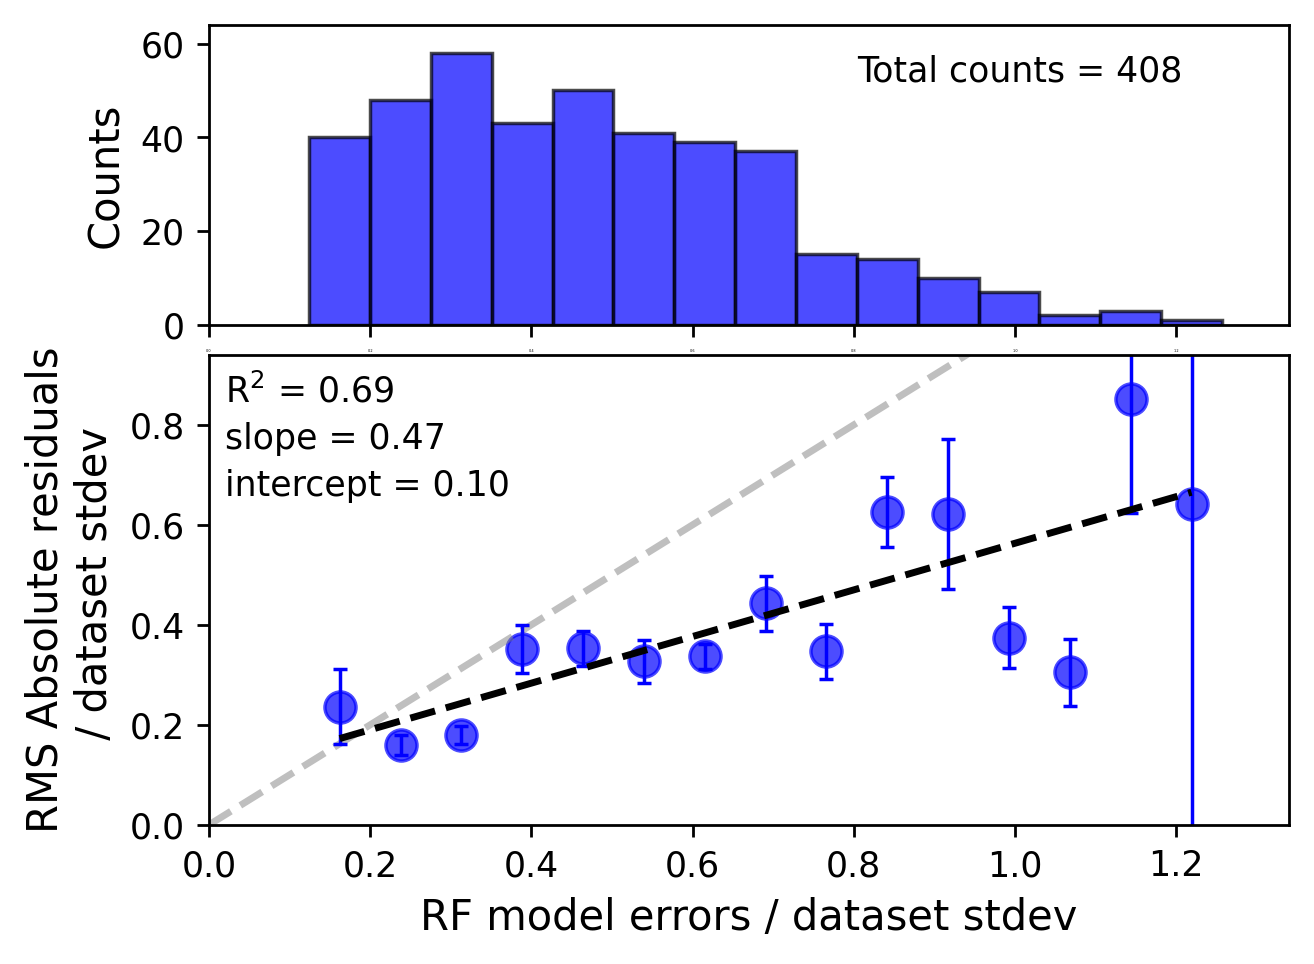

My personal favorite. The residual vs. error plot takes the data shown in the r-statistic distribution and shows how the true errors (residuals) actually correlate with the respective predicted errors. The y-axis are the true errors (residuals) grouped into a finite number of bins. Each data point is the root mean squared residual of that particular bin. The x-axis are the predicted errors. Both axes are normalized by the dataset standard deviation, so they are unitless. The histogram on the top shows the distribution of data points present in each bin. The y=x identity line is plotted. Ideally, you want the data points to fall on this line, because it means the model predicted errors are exactly what you expect based on the true errors. A weighted linear fit (black dashed line) is made to the plotted data. In this case the trend is linear, but the slope is less than one and the intercept is not zero. This indicates that the model is overestimating the true error of the data points, which is also why the r-statistic distribution had a standard deviation less than one. Below, we will see how we can use the method of Palmer, Jacobs and Morgan to recalibrate these uncertainty estimates to more closely align with the true values.

Let's do the run again but this time enable recalibration of errors based on the method of Palmer et al. This is switched on using recalibrate_errors = True

In [ ]:
splitter = SklearnDataSplitter(splitter='RepeatedKFold', n_repeats=1, n_splits=5)
splitter.evaluate(X=X,
                  y=y, 
                  models=[model_rf],
                  mastml=mastml_instance,
                  preprocessor=preprocessor,
                  metrics=metrics,
                  plots=['Error'],
                  savepath=savepath,
                  X_extra=X_extra,
                  nested_CV=True,
                  error_method='stdev_weak_learners', 
                  recalibrate_errors=True,
                  verbosity=2,
                  parallel_run=True)

When error recalibration is enabled, r-statistic and RvE plots are made for both uncalibrated and calibrated data. In addition, summary plots with both cases superposed are produced, as shown here:

### r-statistic plot with and without calibration
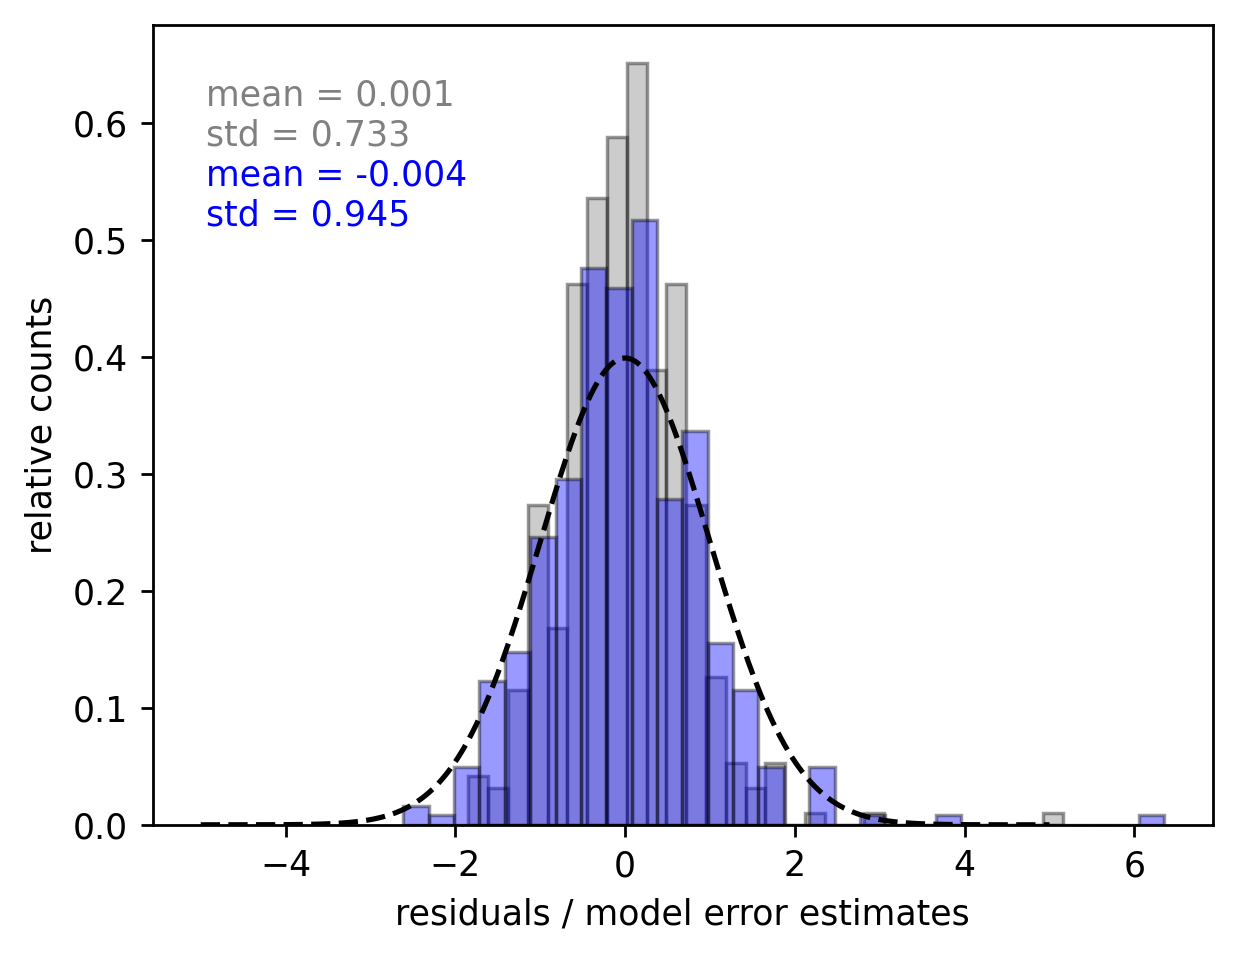

### Residual vs. error plot with and without calibration
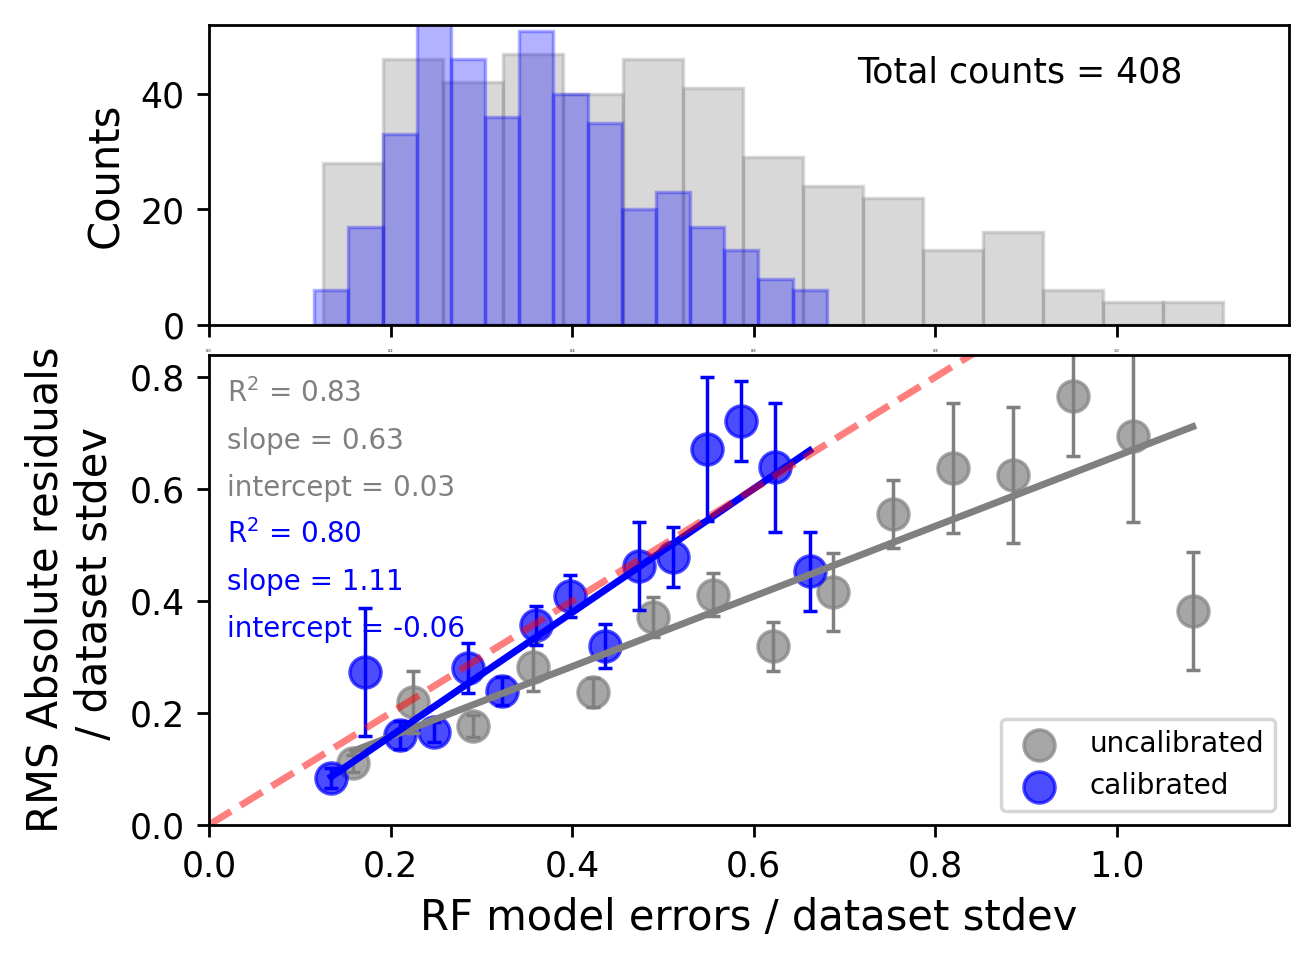

A few things become apparent by examining these figures. From the r-statistic plot, we can see that recalibration results in a mean closer to zero and standard deviation closer to one compared to the uncalibrated case. From the residual vs. error plot, the slope of the fitted line is closer to one (1.11 vs 0.63). In this particular case, the intercept is no closer to zero and the R-squared value has decreased a bit. These effects are due to small sample size. If you have the patience to re-do this run but with n_repeats=5 (total of 625 nested CV splits), the data will look even better and show robust linear correlation for the calibrated case. Overall, the recalibration has improved the model error estimates!

Note that all the model predicted values, their uncertainties (both calibrated and uncalibrated) are saved for the train, test, and left-out datasets. At the outer split level which summarizes the left-out data, the following files summarize the most pertinent data:

y_leaveout : all the true left out data

y_pred_leaveout : all the predicted left out data

model_errors_leaveout : all the uncalibrated model uncertainties

model_errors_leaveout_calibrated : all the calibrated model uncertainties (only written if recalibrate_errors = True)

recalibration_parameters_average_test : the average values of the recalibration parameters obtained from all of the inner train/test CV splits


## Task 3: Explore different methods of quantifying and calibrating model uncertainties <a name="task3"></a>

In addition to the method of Palmer et al. to recalibrate the model uncertainty estimates, a
well-known method called "jackknife after bootstrap" developed by Efron, Wager, and colleagues
is also popular. We can compare how this method performs with that of Palmer et al. by switching
the error_method parameter to be "jackknife_after_bootstrap"

In [ ]:
splitter = SklearnDataSplitter(splitter='RepeatedKFold', n_repeats=1, n_splits=5)
splitter.evaluate(X=X,
                  y=y, 
                  models=[model_rf],
                  mastml=mastml_instance,
                  preprocessor=preprocessor,
                  metrics=metrics,
                  plots=['Error'],
                  savepath=savepath,
                  X_extra=X_extra,
                  nested_CV=True,
                  error_method='jackknife_after_bootstrap', 
                  recalibrate_errors=True,
                  verbosity=2,
                  parallel_run=True)

### r-statistic plot with and without calibration (jackknife after bootstrap)
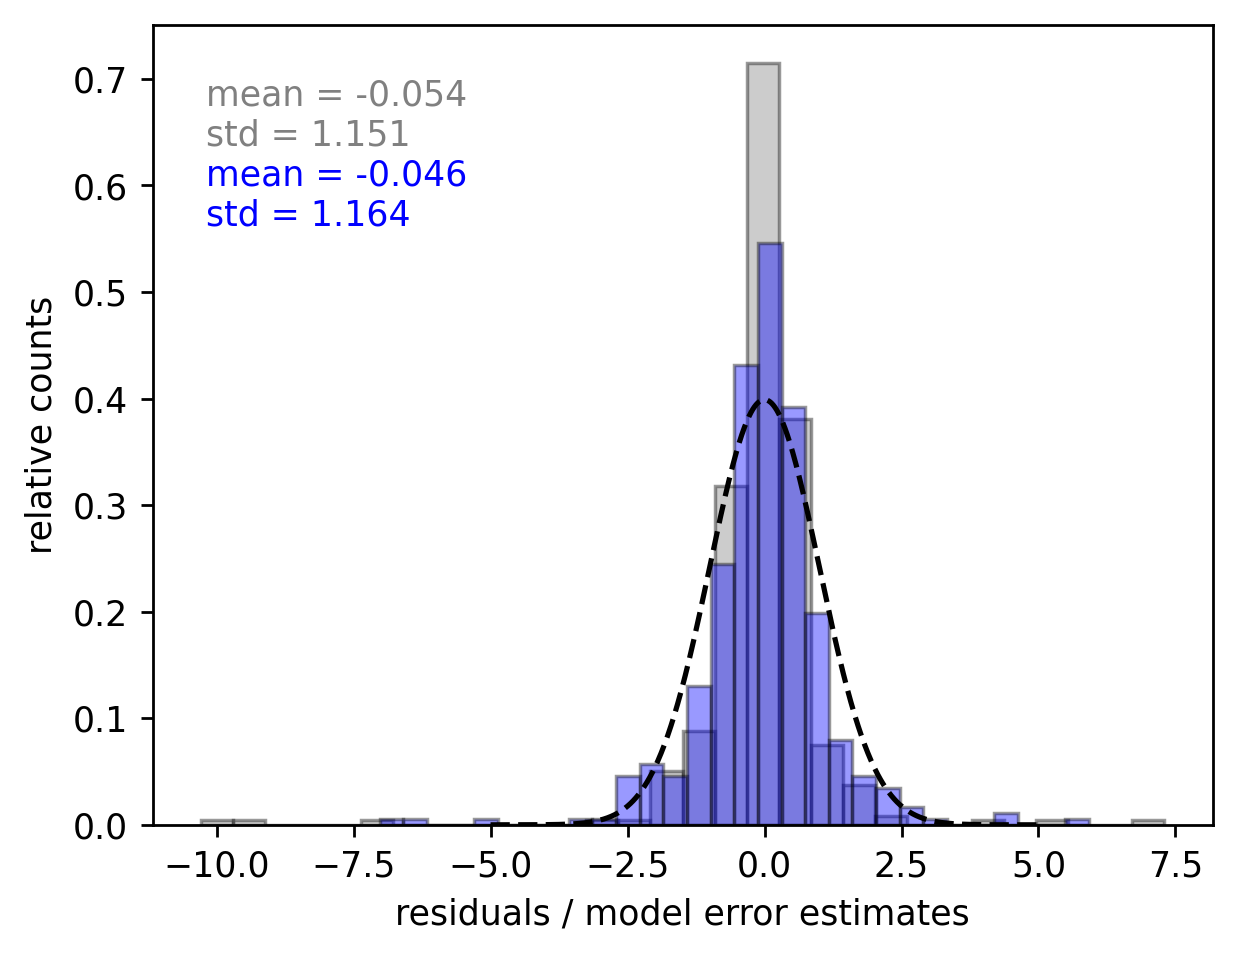

### Residual vs. error plot with and without calibration (jackknife after bootstrap)
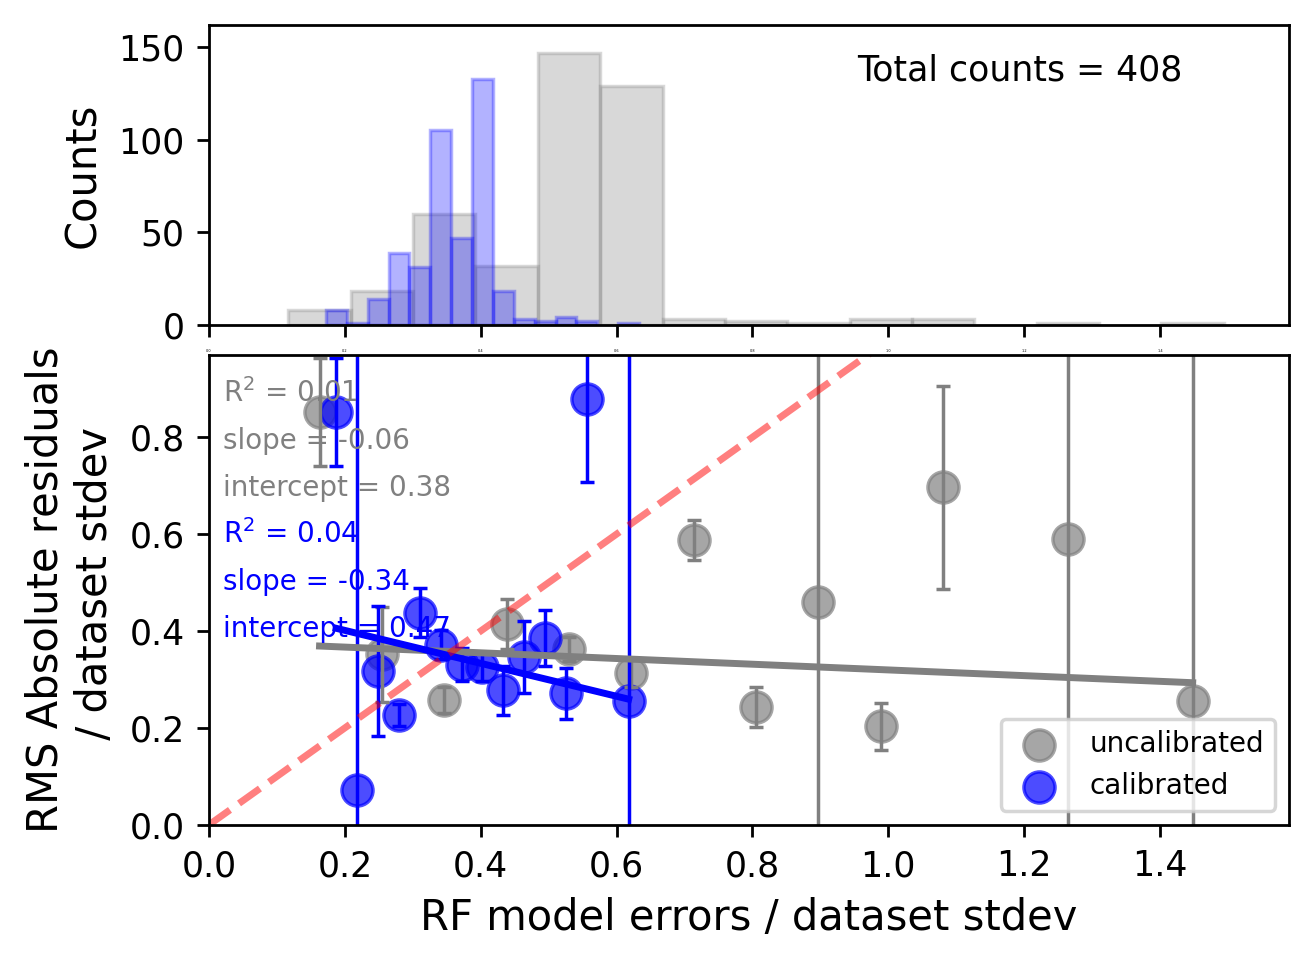

From inspecting these plots and comparing them with the above plots obtained using standard deviation of weak learners, we can see that, for this particular dataset and CV test at least, that using jackknife after bootstrap to obtain error estimates results in worse approximation of the true errors than if the standard deviation of weak learners is used. Application of the recalibration method of Palmer et al. helps a bit to correct for this, but the estimates are still worse than those shown above and show very little correlation overall. 

## Task 4: Compare the uncertainty quantification behavior of Bayesian and ensemble-based models <a name="task4"></a>

Besides ensemble methods, Bayesian methods offer a direct means to obtain an error bar for each predicted data point. Here, we examine the behavior of the error bars obtained for Gaussian Process Regression and compare them to the behavior of the random forest models we looked at above

In [ ]:
model_gpr = SklearnModel(model='GaussianProcessRegressor', kernel='ConstantKernel*RBF', n_restarts_optimizer=10)

splitter = SklearnDataSplitter(splitter='RepeatedKFold', n_repeats=1, n_splits=5)
splitter.evaluate(X=X,
                  y=y, 
                  models=[model_gpr],
                  mastml=mastml_instance,
                  preprocessor=preprocessor,
                  metrics=metrics,
                  plots=['Error'],
                  savepath=savepath,
                  X_extra=X_extra,
                  nested_CV=True,
                  recalibrate_errors=True,
                  verbosity=3,
                  parallel_run=True)

### r-statistic plot (GPR)
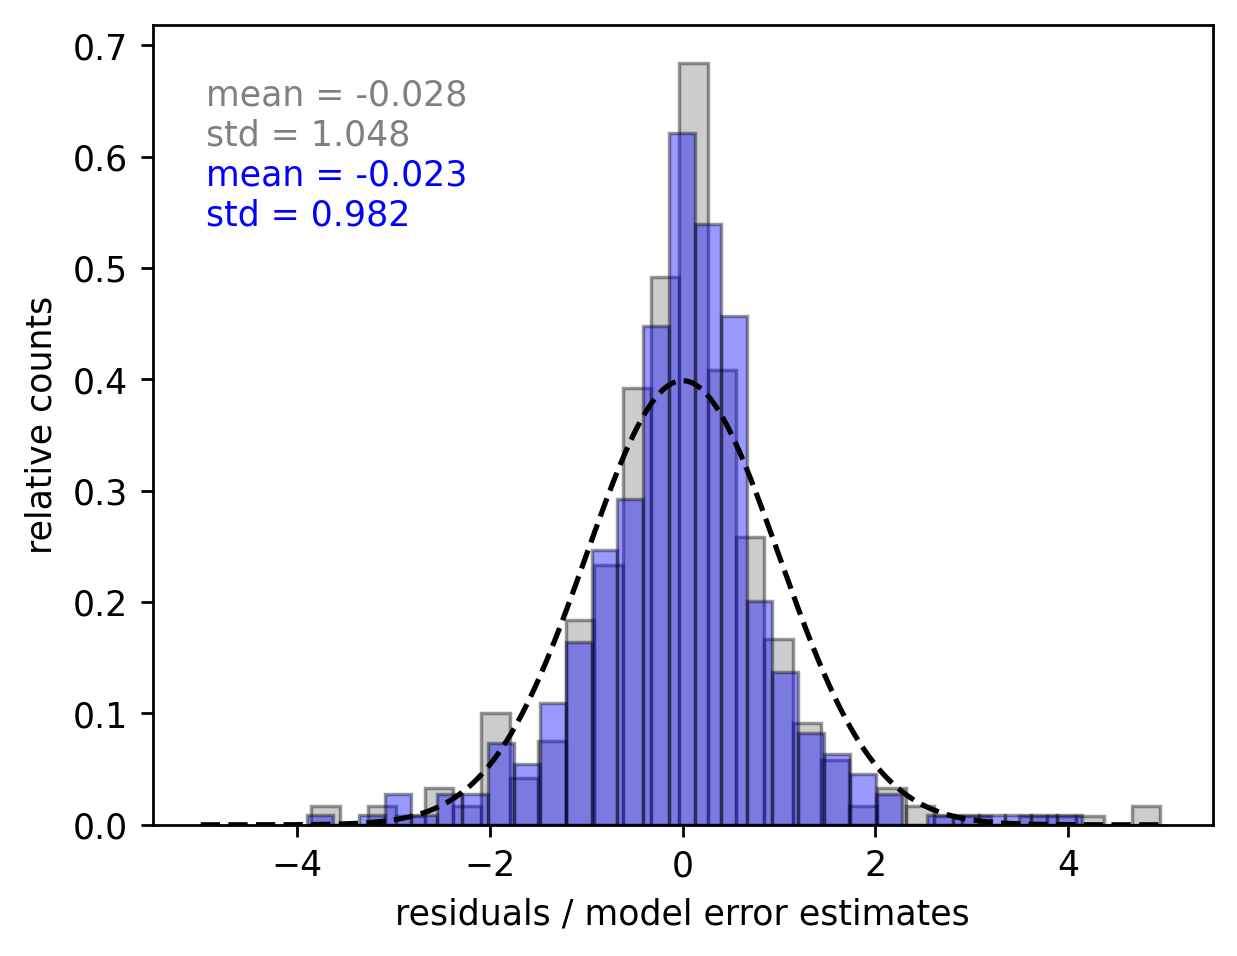

### Residual vs. error plot (GPR)
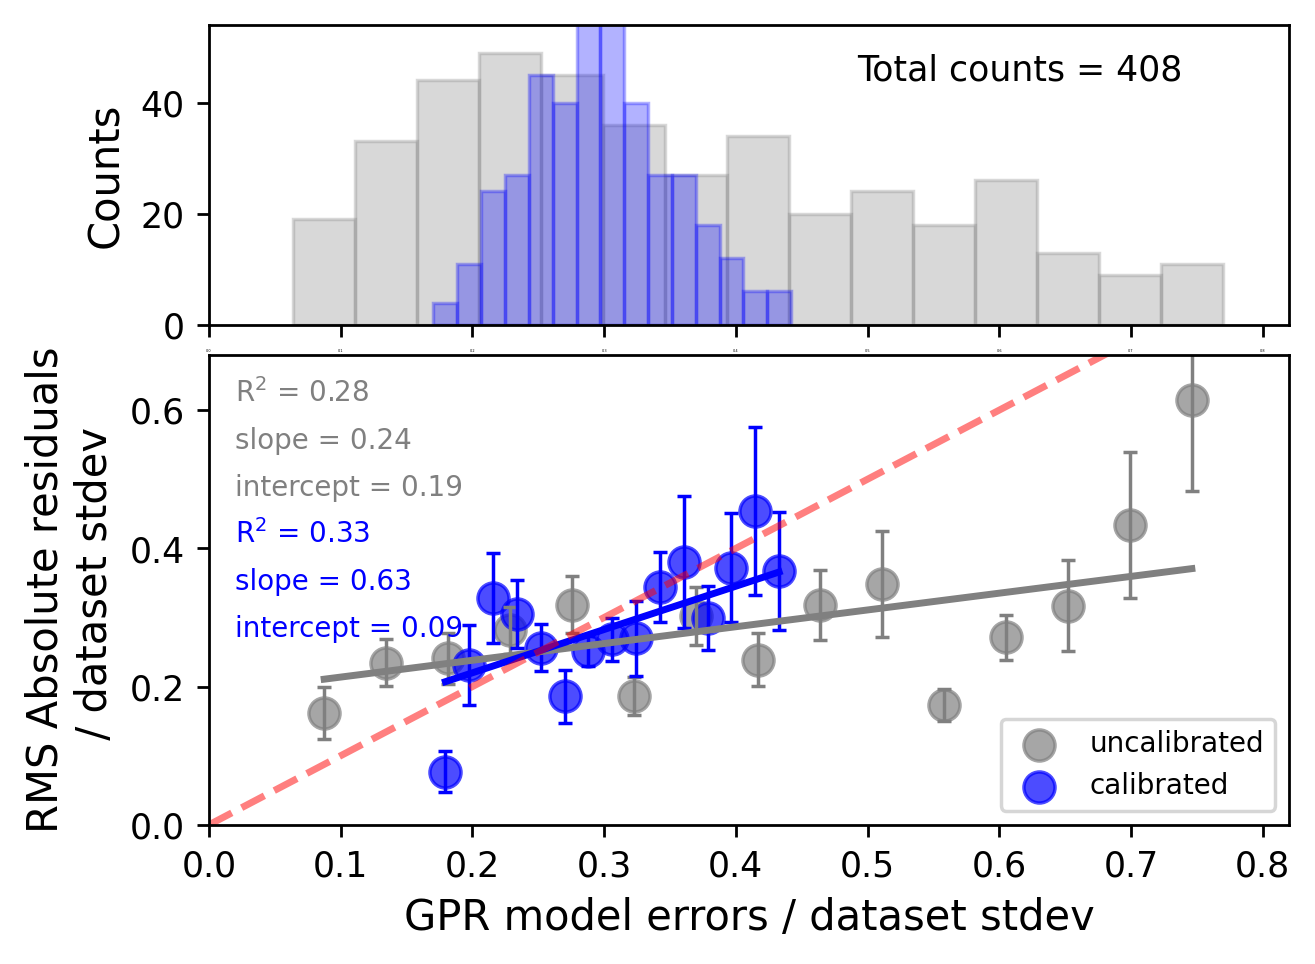

For the case of GPR, the r-statistic plot prior to calibration has a standard deviation greater than one. Contrary to the random forest case, this indicates that GPR is tending to underestimate the true error. After calibration, the standard deviation is very close to one. 

For the residual vs. error plot, there is comparably small correlation between the true and predicted errors relative to the random forest model investigated earlier. One interesting thing we have found, but won't do here as it is very computationally expensive, is that if you build an ensemble of GPR models, you will find, at least for this dataset, highly linear and well-correlated uncertainty estimates!

You've now completed your sixth MAST-ML tutorial notebook! 

The next example in this notebook series is titled MASTML_Tutorial_7_ModelPredictions_with_CalibratedErrorBars.ipynb, 
and will guide you through the process of using a trained model to make predictions on new data, and also the method to obtain predictions with calibrated uncertainties.